In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from tensorflow import keras
from sklearn.metrics import roc_curve
from astroML.utils import completeness_contamination


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.tree import DecisionTreeClassifier as DTC
from astroML.classification import GMMBayes as GMMB

import tensorflow as tf
import datetime


2023-09-07 09:25:19.002139: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#loading data

data=pd.read_csv('galaxyquasar.csv')

#computing colours and normalizing them

ug=np.array(data['u']-data['g'])
gr=np.array(data['g']-data['r'])
ri=np.array(data['r']-data['i'])
iz=np.array(data['i']-data['z'])

ug=(ug-np.ones(len(ug))*np.mean(ug))/np.std(ug)
gr=(gr-np.ones(len(gr))*np.mean(gr))/np.std(gr)
ri=(ri-np.ones(len(ri))*np.mean(ri))/np.std(ri)
iz=(iz-np.ones(len(iz))*np.mean(iz))/np.std(iz)


#building colour vector

X=np.column_stack((ug,gr,ri,iz))

#finding labels

labels=data['class']
y=np.where(np.array(labels)=='QSO',1,0)

#dividing the dataset in a test and train sets

(x_train, x_test),(y_train, y_test)= split_samples(X, y, [0.7, 0.3],random_state=0)

469/469 [==============================] - 1s 1ms/step


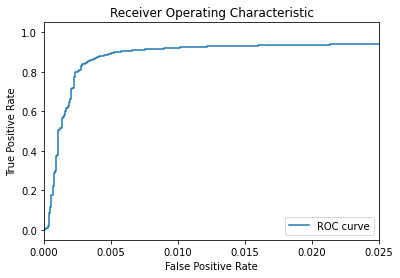

completeness = 0.9435676709708274
contamination = 0.08189855746859004




In [3]:
#clearing previous sessions
tf.keras.backend.clear_session()

#defining the model: a layer with 5 neurons and a layer for the output

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation='relu'), #layer with 5 neurons
        tf.keras.layers.Dense(2, activation='relu')]) #output, we want two classes

#defining the optimizer

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

#compiling the model and fitting

model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy']);
model.fit(x_train, y_train, epochs=1);

#making label predictions

probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

#y_pred[0]=prop of class 0, y_pred[1]=prob of class 1

y_pred=probability_model.predict(x_test)

#plotting the ROC curve

#roc_curve(y_test=y_test, prob of the positive class=y_pred[1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1]) 
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim(0.0,0.025)
plt.show()

#computing completeness and contamination

completeness, contamination = completeness_contamination(y_test,np.where(y_pred[:,1]>y_pred[:,0],1,0))
efficiency=1-completeness
print('completeness =',completeness)
print('contamination =', contamination)
print('\n')


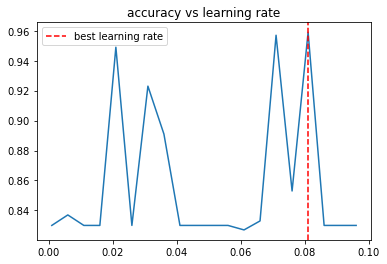

In [4]:
#searching for the best learning rate

#defining an accuracy vector

accuracy=[]


for l_r in np.arange(0.001,0.1,0.005):
    
    #defining the network using the current learning rate
    
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu')])
    
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    
    #compiling the model and compiling
    
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy']);
    model.fit(x_train, y_train, epochs=1,verbose=0);
    
    #add the current accuracy to the vector
    
    accuracy.append(model.evaluate(x_train[0:1000],y_train[0:1000],verbose=0)[1])

#plotting the accuracy as a function of the learning rate

plt.plot(np.arange(0.001,0.1,0.005),accuracy)

#best parameter

plt.axvline(np.arange(0.001,0.1,0.005)[np.where(accuracy==np.max(accuracy))][0],linestyle='--',c='red',label='best learning rate')
plt.title('accuracy vs learning rate')
plt.legend()
plt.show()

best_lr=np.arange(0.001,0.1,0.005)[np.where(accuracy==np.max(accuracy))][0]

469/469 [==============================] - 1s 1ms/step


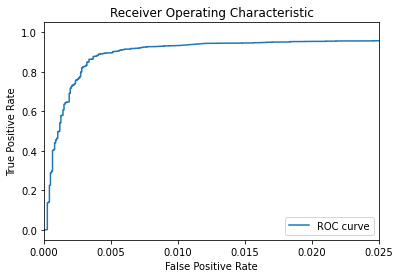

completeness = 0.9391100702576113
contamination = 0.06700791065611912




In [6]:
#clearing previous sessions

tf.keras.backend.clear_session()

#defining the model: a layer with 5 neurons and a layer for the output

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation='relu'), #layer with 5 neurons
        tf.keras.layers.Dense(2, activation='relu')]) #output, we want two classes

#defining the optimizer

optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr)

#compiling the model and fitting

model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy']);
model.fit(x_train, y_train, epochs=1);

#making label predictions

probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

#y_pred[0]=prop of class 0, y_pred[1]=prob of class 1

y_pred=probability_model.predict(x_test)

#plotting the ROC curve

#roc_curve(y_test=y_test, prob of the positive class=y_pred[1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1]) 
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim(0.0,0.025)
plt.show()

completeness, contamination = completeness_contamination(y_test,np.where(y_pred[:,1]>y_pred[:,0],1,0))
efficiency=1-completeness
print('completeness =',completeness)
print('contamination =', contamination)
print('\n')

469/469 [==============================] - 1s 1ms/step


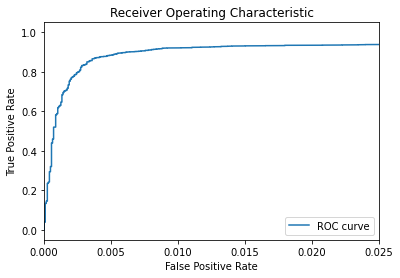

completeness = 0.9656392117230924
contamination = 0.11074918566775244




In [7]:
# clearing possible previous sessions

tf.keras.backend.clear_session()

#creating a model

model = tf.keras.models.Sequential([
    tf.keras.layers.ActivityRegularization(l1=0.001,l2=0.001),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy']);

#fitting our data
model.fit(x_train, y_train, epochs=1);

#making label predictions

probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

#y_pred[0]=prop of class 0, y_pred[1]=prob of class 1

y_pred=probability_model.predict(x_test)

#plotting the ROC curve

#roc_curve(y_test=y_test, prob of the positive class=y_pred[1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1]) 
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim(0.0,0.025)
plt.show()

completeness, contamination = completeness_contamination(y_test,np.where(y_pred[:,1]>y_pred[:,0],1,0))
efficiency=1-completeness
print('completeness =',completeness)
print('contamination =', contamination)
print('\n')

LinearDiscrimin

completeness = 0.9292694276407631
contamination = 0.058462989156058465


------------------------------
QuadraticDiscri

completeness = 0.9260120986505351
contamination = 0.06484962406015038


------------------------------
GaussianNB()

completeness = 0.9185667752442996
contamination = 0.10719131614654002


------------------------------
KNeighborsClass

completeness = 0.9395067473243369
contamination = 0.04085510688836105


------------------------------
DecisionTreeCla

completeness = 0.9371800837598884
contamination = 0.04459203036053131


------------------------------
GMMBayes(n_comp

completeness = 0.9329920893438809
contamination = 0.14498933901918976


------------------------------


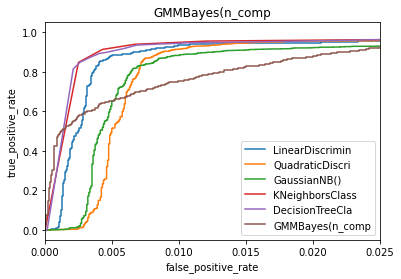

In [8]:
#comparing with other classifiers

#classifiers that I'll use

Classifiers=[
    LDA(),
    QDA(),
    GNB(),
    KN(),
    DTC(random_state=42, max_depth=5,criterion='entropy'),
    GMMB(n_components=2, tol=1E-5,covariance_type='full')]

colors=[ug,gr,ri,iz]

for classifier in Classifiers:
    
    print(str(classifier)[:15]+'\n')
        
        
    #fitting
    clf=classifier
    clf.fit(x_train, y_train)
    
    #computing probabilities and predicting
    
    y_probs_clf = clf.predict_proba(x_test)[:, 1]
    y_pred = clf.predict(x_test)
    
    #computing completness and contamination
    
    completeness, contamination = completeness_contamination(y_pred, y_test)
    efficiency=1-completeness
    
    print('completeness =',completeness)
    print('contamination =', contamination)
    print('\n')
    
    #computing the true and false positive rates
    
    false_positive_rate, true_positive_rate, thresh = roc_curve(y_test, y_probs_clf)
    
    #plotting ROC curves
    
    plt.plot(false_positive_rate,true_positive_rate,label=str(classifier)[:15])
    plt.xlim(0, 0.025)
    plt.xlabel('false_positive_rate')
    plt.ylabel('true_positive_rate')
    plt.title(str(classifier)[:15])
    plt.legend()
    print('------------------------------')
plt.show()